In [54]:
from model_2 import *
from data_2 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [55]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [56]:
N_training = 150
N_validate = 15
batch_size = 4

train_ids = np.arange(N_training)
print(train_ids)
train_generator = DataGenerator(train_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

validation_ids = np.arange(N_training, N_training+N_validate)
print(validation_ids)
validation_generator = DataGenerator(validation_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Initialized with 3750 total IDs
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
Initialized with 375 total IDs


In [57]:
with tf.device('/GPU:1'):
    model = unet(init_layers=128)
    print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 256, 256, 128 2432        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 256, 256, 128 147584      conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_70[0][0]                  
____________________________________________________________________________________________

In [58]:
# Load test data
cardiac_test = np.load('../tagsim/test_data_v1.npz')

truth_data = cardiac_test['truth']

test_data = cardiac_test['test']

X = np.zeros(test_data.shape + (2,))
y = np.zeros(truth_data.shape + (2,))

X[:,:,:,0] = np.real(test_data)
X[:,:,:,1] = np.imag(test_data)

y[:,:,:,0] = np.real(truth_data)
y[:,:,:,1] = np.imag(truth_data)

with tf.device('/GPU:2'):
    res = model.predict(X)

In [59]:
print(X.shape)
print(y.shape)

(25, 256, 256, 2)
(25, 256, 256, 2)


In [60]:
with tf.device('/GPU:1'):
    hist = model.fit_generator(train_generator, validation_data= (X,y) , epochs=12)

Epoch 1/12
937/937 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0027

ResourceExhaustedError:  OOM when allocating tensor with shape[25,512,129,129] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node model_3/conv2d_85/Conv2D (defined at <ipython-input-60-b354daf376c5>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_79324]

Function call stack:
test_function


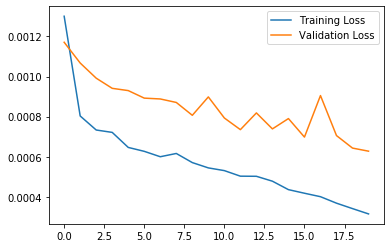

In [19]:
plt.figure()
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()

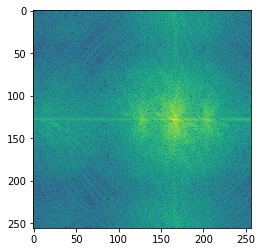

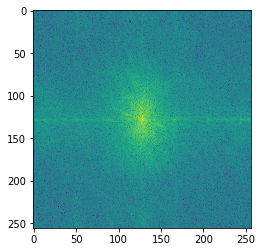

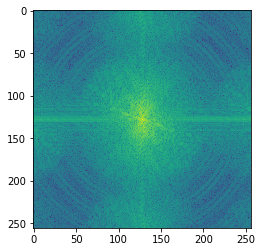

In [27]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_X))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_res[11]))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_truth[11]))))))

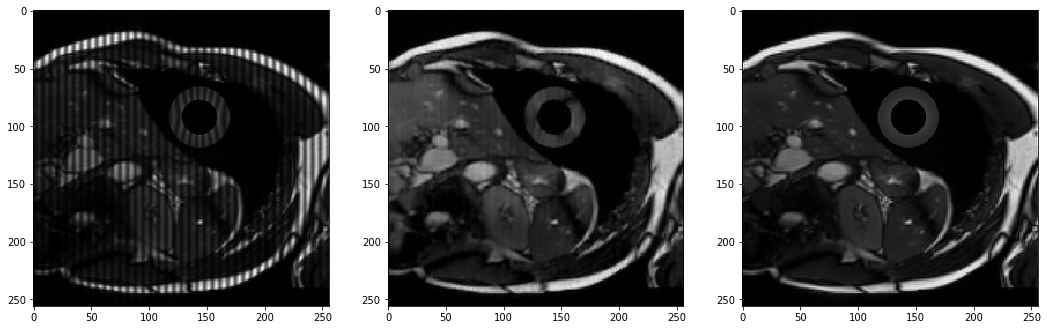

In [28]:
#Visualize magnitude of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.abs(im_X)), cmap='gray')
axs[0,1].imshow((np.abs(im_res)), cmap='gray')
axs[0,2].imshow((np.abs(im_truth)), cmap='gray')

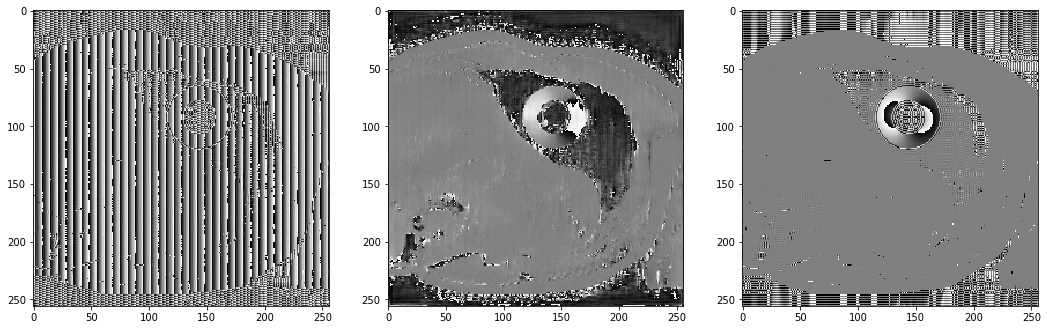

In [29]:
#Visualize phase of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.angle(im_X)), cmap='gray')
axs[0,1].imshow((np.angle(im_res)), cmap='gray')
axs[0,2].imshow((np.angle(im_truth)), cmap='gray')

Time resolved mean error: [0.05651819, 0.038972937, 0.03963146, 0.03675127, 0.012493278, -0.053519957, -0.10882235, -0.18296379, -0.22878304, -0.2766617, -0.32183287, -0.36498782, -0.4097793, -0.43885586, -0.44219673, -0.40738776, -0.37161452, -0.28284347, -0.16036743, -0.014244091, 0.1943832, 0.29413444, 0.35874397, 0.40510854, 0.5097375]
Time resolved stdev error: [0.08474564, 0.09225127, 0.136492, 0.19822313, 0.2477299, 0.32954973, 0.41359702, 0.4956088, 0.58728516, 0.6910261, 0.78439665, 0.9211389, 1.1001316, 1.1857346, 1.2537111, 1.3130447, 1.3740331, 1.3578908, 1.2246492, 1.1014508, 0.8819701, 0.7462386, 0.5281281, 0.28775212, 0.22108895]
Total Error: 0.6197226 mm  +/- 0.63035625 mm


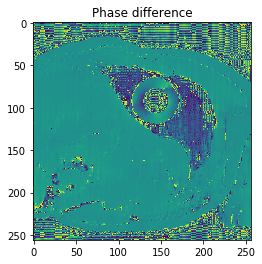

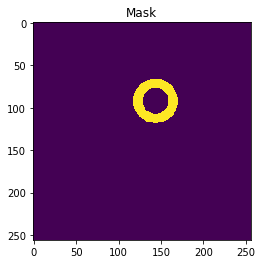

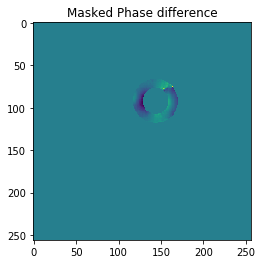

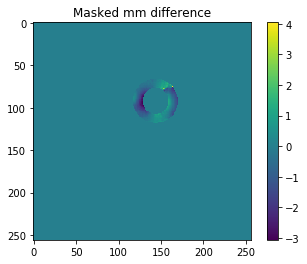

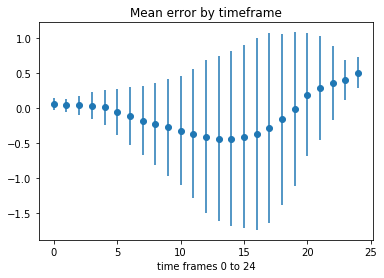

In [30]:
# Compute error:

# Phase difference of results and truth
im_res = res[:,:,:,0] + 1j * res[:,:,:,1]
im_truth = truth_data
ph_diff = np.angle(im_res * np.exp(-1j * np.angle(im_truth)))


# Plot phase difference
tt_show = 11  # timeframe to look at
plt.figure()
plt.imshow(ph_diff[tt_show])
plt.title('Phase difference')

# We dont actually care about anything but the hard, I saved a mask in the test dataset
mask = cardiac_test['mask']
plt.figure()
plt.imshow(mask[tt_show])
plt.title('Mask')

# Multiply results by the mask
ph_diff_mask = ph_diff * mask
plt.figure()
plt.imshow(ph_diff_mask[tt_show])
plt.title('Masked Phase difference')

# Convert to mm error
ke = 0.12 # This was set in simulation
mm_diff_mask = ph_diff_mask / (2*np.pi) / ke
plt.figure()
plt.imshow(mm_diff_mask[tt_show])
plt.colorbar()
plt.title('Masked mm difference')

# Calculate mean and standard deviation error, time frame specific
# We mask differently because we don't want to incorporate all the zeros from masking
err_mean = []
err_std = []
for tt in range(im_res.shape[0]):
    t_diff = mm_diff_mask[tt, mask[tt]>0]
    err_mean.append(t_diff.mean())
    err_std.append(t_diff.std())

print('Time resolved mean error:', err_mean)
print('Time resolved stdev error:', err_std)
x_ax = np.arange(25)
plt.figure()
plt.errorbar(x_ax, err_mean, yerr = err_std, fmt='o')
plt.title('Mean error by timeframe')
plt.xlabel("time frames 0 to 24")

# And the total error as a single metric
total_err = mm_diff_mask[mask>0]
print('Total Error:', np.abs(total_err).mean(), 'mm  +/-', np.abs(total_err).std(), 'mm')

## Tuning ideas
* Use all timeframes together
  * As channels (3D convolutions will be too expensive)
* Operate in k-space
* Which loss function is best
* Operate in image space, but loss function in k-space
* Play with activation functions, where to use batch normalization, learning rate adjustments, batch size
* Check initial image normalization (zero mean, stdev = 1)

## Implement validation, test data
* Validate on different simulations
* Test on the cardiac simulation
* Eventually we will test on our acquired DENSE data (I need to prep it)

In [ ]:
list(cardiac_test.keys())

In [ ]:
X.shape

In [ ]:
X.shape